In [4]:
from brian2 import *
%matplotlib inline

start_scope()

#basic neuronal group characteristics
neurons_num = 12 #referring to the number of stuctures and subgroups sizes

v_rest = -70*mV #resting potential
v_th = -50*mV #threshold potential
area = 0.785*umetre**2 
Cm = 1*ufarad*cm**-2 * area
v_eK = -90*mV
v_eNa = 50*mV
g_Na = 100*msiemens*cm**-2 * area
g_K = 30*msiemens*cm**-2 * area
VT = -63*mV


#Hodgkin-Huxley model equations
eqs = '''
dv/dt = -(g_Na*(m*m*m)*h*(v-v_eNa) + g_K*(n*n*n*n)*(v-v_eK) + I_stim)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
receptors_num : 1
v_e : volt
W : metre**3
Kd : mM
gam : siemens
L : mM
dI_stim/dt = (receptors_num*(v - v_e)*gam*((L/W/Kd)/(1*metre**-3 + (L/W/Kd))))/ms : amp

'''

model_glu = '''
receptors_num_syn : 1
v_e_syn : volt
W_syn : metre**3
Kd_syn : mM
gam_syn : siemens
L_syn : mM
dI_stim_syn/dt = (receptors_num*(v - v_e)*gam*((L/W/Kd)/(1*metre**-3 + (L/W/Kd))))/ms : amp (event-driven)

'''

Prototype = NeuronGroup(neurons_num, eqs, threshold='v > v_th', reset='v = v_rest')
Prototype.v = v_rest
Prototype.receptors_num = 2400
Prototype.v_e = +55*mV
Prototype.gam = 10*psiemens
Prototype.W = 20*nmeter * area
Prototype.Kd = 500*nM
Prototype.L = 1.1*mM

In [5]:
#Setting up test synapse
#excitatory synapse (glutamate)
S_012 = Synapses(Prototype, Prototype, model = Equations(model_glu))
S_012.connect(i=[0], j=[1, 2])
S_012.receptors_num_syn = 2400
S_012.v_e_syn = +55*mV
S_012.gam_syn = 10*psiemens
S_012.W_syn = 20*nmeter * area
S_012.Kd_syn = 500*nM
S_012.L_syn = 1.1*mM

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.05s, trying other methods took 0.26s). [brian2.stateupdaters.base.method_choice]


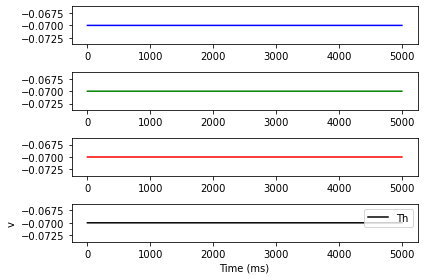

In [6]:
import numpy as np
import matplotlib.pyplot as plt

M = StateMonitor(Prototype, 'v', record=True)

run(5000*ms)

fig, axs = plt.subplots(4)
axs[0].plot(M.t/ms, M.v[0], color='blue', label='')
axs[1].plot(M.t/ms, M.v[1], color='green', label='')
axs[2].plot(M.t/ms, M.v[2], color='red', label='Th')
axs[3].plot(M.t/ms, M.v[4], color='black', label='Th')
plot()

xlabel('Time (ms)')
ylabel('v')
legend();

#set the spacing between subplots
fig.tight_layout()
plt.show()

Документация по классу "Синапс":

In [ ]:
'''
Module providing the `Synapses` class and related helper classes/functions.
'''
from collections import defaultdict
from collections.abc import Sequence, MutableMapping, Mapping
import functools
import weakref
import re
import numbers

import numpy as np

from brian2.core.base import weakproxy_with_fallback
from brian2.core.base import device_override
from brian2.core.namespace import get_local_namespace
from brian2.core.variables import (DynamicArrayVariable, Variables)
from brian2.codegen.codeobject import create_runner_codeobj
from brian2.codegen.translation import get_identifiers_recursively
from brian2.devices.device import get_device
from brian2.equations.equations import (Equations, SingleEquation,
                                        DIFFERENTIAL_EQUATION, SUBEXPRESSION,
                                        PARAMETER, INTEGER,
                                        check_subexpressions)
from brian2.groups.group import Group, CodeRunner, get_dtype
from brian2.groups.neurongroup import (extract_constant_subexpressions,
                                       SubexpressionUpdater,
                                       check_identifier_pre_post)
from brian2.parsing.expressions import is_boolean_expression, parse_expression_dimensions
from brian2.stateupdaters.base import (StateUpdateMethod,
                                       UnsupportedEquationsException)
from brian2.stateupdaters.exact import linear, independent
from brian2.units.fundamentalunits import (Quantity, DIMENSIONLESS, DimensionMismatchError,
                                           fail_for_dimension_mismatch)
from brian2.units.allunits import second
from brian2.utils.logger import get_logger
from brian2.utils.stringtools import get_identifiers, word_substitute
from brian2.utils.arrays import calc_repeats
from brian2.core.spikesource import SpikeSource
from brian2.synapses.parse_synaptic_generator_syntax import parse_synapse_generator
from brian2.parsing.bast import brian_ast
from brian2.parsing.rendering import NodeRenderer

MAX_SYNAPSES = 2147483647

__all__ = ['Synapses']

logger = get_logger(__name__)


[docs]class StateUpdater(CodeRunner):
    '''
    The `CodeRunner` that updates the state variables of a `Synapses`
    at every timestep.
    '''
    def __init__(self, group, method, clock, order, method_options=None):
        self.method_choice = method
        self.method_options = method_options
        CodeRunner.__init__(self, group,
                            'stateupdate',
                            clock=clock,
                            when='groups',
                            order=order,
                            name=group.name + '_stateupdater',
                            check_units=False,
                            generate_empty_code=False)
    
[docs]    def update_abstract_code(self, run_namespace):
        if len(self.group.equations) > 0:
            # Resolve variables in the equations to correctly perform checks
            # for repeated stateful functions (e.g. rand() calls)
            names = self.group.equations.names
            external_names = self.group.equations.identifiers | {'dt'}

            variables = self.group.resolve_all(names | external_names,
                                               run_namespace,
                # we don't need to raise any warnings
                # for the user here, warnings will
                # be raised in create_runner_codeobj
                user_identifiers=set())
            stateupdate_output = StateUpdateMethod.apply_stateupdater(self.group.equations,
                                                                      variables,
                                                                      self.method_choice,
                                                                      method_options=self.method_options,
                                                                      group_name=self.group.name)
            if isinstance(stateupdate_output, str):
                self.abstract_code = stateupdate_output
            else:
                # Note that the reason to send self along with this method is so the StateUpdater
                # can be modified! i.e. in GSL StateUpdateMethod a custom CodeObject gets added
                # to the StateUpdater together with some auxiliary information
                self.abstract_code = stateupdate_output(self)
        else:
            self.abstract_code = ''



[docs]class SummedVariableUpdater(CodeRunner):
    '''
    The `CodeRunner` that updates a value in the target group with the
    sum over values in the `Synapses` object.
    '''
    def __init__(self, expression, target_varname, synapses, target,
                 target_size_name, index_var):
        # Handling sumped variables using the standard mechanisms is not
        # possible, we therefore also directly give the names of the arrays
        # to the template.

        code = '''
        _synaptic_var = {expression}
        '''.format(expression=expression,
                   target_varname=target_varname)
        self.target_varname = target_varname
        self.expression = expression
        self.target_var = synapses.variables[target_varname]
        self.target = target
        template_kwds = {'_target_var': self.target_var,
                         '_target_size_name': target_size_name,
                         '_index_var': synapses.variables[index_var],
                         '_target_start': getattr(target, 'start', 0),
                         '_target_stop': getattr(target, 'stop', -1)}

        CodeRunner.__init__(self, group=synapses,
                            template='summed_variable',
                            code=code,
                            needed_variables=[target_varname, target_size_name,
                                              index_var],
                            # We want to update the summed variable before
                            # the target group gets updated
                            clock=target.clock,
                            when='groups',
                            order=target.order-1,
                            name=synapses.name + '_summed_variable_' + target_varname,
                            template_kwds=template_kwds)



[docs]class SynapticPathway(CodeRunner, Group):
    '''
    The `CodeRunner` that applies the pre/post statement(s) to the state
    variables of synapses where the pre-/postsynaptic group spiked in this
    time step.

    Parameters
    ----------

    synapses : `Synapses`
        Reference to the main `Synapses` object
    prepost : {'pre', 'post'}
        Whether this object should react to pre- or postsynaptic spikes
    objname : str, optional
        The name to use for the object, will be appendend to the name of
        `synapses` to create a name in the sense of `Nameable`. If ``None``
        is provided (the default), ``prepost`` will be used.
    delay : `Quantity`, optional
        A scalar delay (same delay for all synapses) for this pathway. If
        not given, delays are expected to vary between synapses.
    '''
    def __init__(self, synapses, code, prepost, objname=None,
                 delay=None, event='spike'):
        self.code = code
        self.prepost = prepost
        self.event = event
        if prepost == 'pre':
            self.source = synapses.source
            self.target = synapses.target
            self.synapse_sources = synapses.variables['_synaptic_pre']
            self.synapse_targets = synapses.variables['_synaptic_post']
            order = -1
        elif prepost == 'post':
            self.source = synapses.target
            self.target = synapses.source
            self.synapse_sources = synapses.variables['_synaptic_post']
            self.synapse_targets = synapses.variables['_synaptic_pre']
            order = 1
        else:
            raise ValueError('prepost argument has to be either "pre" or '
                             '"post"')
        self.synapses = weakref.proxy(synapses)
        # Allow to use the same indexing of the delay variable  as in the parent
        # Synapses object (e.g. 2d indexing with pre- and post-synaptic indices)
        self._indices = self.synapses._indices

        if objname is None:
            objname = prepost

        CodeRunner.__init__(self, synapses,
                            'synapses',
                            code=code,
                            clock=self.source.clock,
                            when='synapses',
                            order=order,
                            name=synapses.name + '_' + objname,
                            template_kwds={'pathway': self})

        self._pushspikes_codeobj = None

        self.spikes_start = self.source.start
        self.spikes_stop = self.source.stop
        self.eventspace_name = '_{}space'.format(event)
        self.eventspace = None  # will be set in before_run
        # Setting the Synapses object instead of "self" as an owner makes
        # indexing conflicts disappear (e.g. with synapses connecting subgroups)
        self.variables = Variables(synapses)
        self.variables.add_reference(self.eventspace_name, self.source)
        self.variables.add_reference('N', synapses)
        if prepost == 'pre':
            self.variables.add_reference('_n_sources', synapses, 'N_pre')
            self.variables.add_reference('_n_targets', synapses, 'N_post')
            self.variables.add_reference('_source_dt', synapses.source, 'dt')
        else:
            self.variables.add_reference('_n_sources', synapses, 'N_post')
            self.variables.add_reference('_n_targets', synapses, 'N_pre')
            self.variables.add_reference('_source_dt', synapses.target, 'dt')
        if delay is None:  # variable delays
            if getattr(synapses, 'N', None) is not None:
                n_synapses = synapses.N
            else:
                n_synapses = 0
            self.variables.add_dynamic_array('delay', dimensions=second.dim,
                                             size=n_synapses, constant=True)
            # Register the object with the `SynapticIndex` object so it gets
            # automatically resized
            synapses.register_variable(self.variables['delay'])
        else:
            if not isinstance(delay, Quantity):
                raise TypeError(('Cannot set the delay for pathway "%s": '
                                 'expected a quantity, got %s instead.') % (objname,
                                                                            type(delay)))
            if delay.size != 1:
                raise TypeError(('Cannot set the delay for pathway "%s": '
                                 'expected a scalar quantity, got a '
                                 'quantity with shape %s instead.') % str(delay.shape))
            fail_for_dimension_mismatch(delay, second, ('Delay has to be '
                                                        'specified in units '
                                                        'of seconds but got '
                                                        '{value}'),
                                        value=delay)
            # We use a "dynamic" array of constant size here because it makes
            # the generated code easier, we don't need to deal with a different
            # type for scalar and variable delays
            self.variables.add_dynamic_array('delay', dimensions=second.dim,
                                             size=1, constant=True,
                                             scalar=True)
            # Since this array does not grow with the number of synapses, we
            # have to resize it ourselves
            self.variables['delay'].resize(1)
            self.variables['delay'].set_value(delay)

        self._delays = self.variables['delay']

        # Re-extract the last part of the name from the full name
        self.objname = self.name[len(synapses.name) + 1:]


        #: The `CodeObject` initalising the `SpikeQueue` at the begin of a run
        self._initialise_queue_codeobj = None

        self.namespace = synapses.namespace

        # Allow the use of string expressions referring to synaptic (including
        # pre-/post-synaptic) variables
        # Only include non-private variables (and their indices)
        synaptic_vars = {varname for varname in list(synapses.variables)
                         if not varname.startswith('_')}
        synaptic_idcs = {varname: synapses.variables.indices[varname]
                         for varname in synaptic_vars}
        synaptic_vars |= {index_name for index_name in synaptic_idcs.values()
                          if index_name not in ['_idx', '0']}
        self.variables.add_references(synapses, synaptic_vars)
        self.variables.indices.update(synaptic_idcs)

        #: The `SpikeQueue`
        self.queue = get_device().spike_queue(self.source.start, self.source.stop)
        self.variables.add_object('_queue', self.queue)

        self._enable_group_attributes()

[docs]    def check_variable_write(self, variable):
        # Forward the check to the `Synapses` object (raises an error if no
        # synapse has been created yet)
        self.synapses.check_variable_write(variable)


    @device_override('synaptic_pathway_update_abstract_code')
    def update_abstract_code(self, run_namespace=None, level=0):
        if self.synapses.event_driven is not None:
            event_driven_eqs = self.synapses.event_driven
            clock_driven_eqs = self.synapses.equations
            try:
                event_driven_update = linear(event_driven_eqs,
                                             self.group.variables)
            except UnsupportedEquationsException:
                # Check whether equations are independent
                for var, expr in event_driven_eqs.diff_eq_expressions:
                    for identifier in expr.identifiers:
                        if identifier == var:
                            continue
                        if (identifier in event_driven_eqs.diff_eq_names or
                                identifier in clock_driven_eqs):
                            err = ("Cannot solve the differential equation for "
                                   "'{}' as event-driven, it depends on "
                                   "another variable '{}'. Use (clock-driven) "
                                   "instead.".format(var,
                                                                    identifier))
                            raise UnsupportedEquationsException(err)
                # All equations are independent, go ahead
                event_driven_update = independent(self.synapses.event_driven,
                                                  self.group.variables)
            # TODO: Any way to do this more elegantly?
            event_driven_update = re.sub(r'\bdt\b', '(t - lastupdate)',
                                         event_driven_update)

            self.abstract_code = event_driven_update + '\n'
        else:
            self.abstract_code = ''

        self.abstract_code += self.code + '\n'
        if self.synapses.event_driven is not None:
            self.abstract_code += 'lastupdate = t\n'

    @device_override('synaptic_pathway_before_run')
    def before_run(self, run_namespace):
        super(SynapticPathway, self).before_run(run_namespace)

[docs]    def create_code_objects(self, run_namespace):
        if self._pushspikes_codeobj is None:
            # Since this now works for general events not only spikes, we have to
            # pass the information about which variable to use to the template,
            # it can not longer simply refer to "_spikespace"
            # Strictly speaking this is only true for the standalone mode at the
            # moment, since in runtime, all the template does is to call
            # SynapticPathway.push_spike
            eventspace_name = '_{}space'.format(self.event)
            template_kwds = {'eventspace_variable': self.source.variables[eventspace_name]}
            needed_variables = [eventspace_name]
            self._pushspikes_codeobj = create_runner_codeobj(self,
                                                             '', # no code
                                                             'synapses_push_spikes',
                                                             name=self.name+'_push_spikes',
                                                             check_units=False,
                                                             additional_variables=self.variables,
                                                             needed_variables=needed_variables,
                                                             template_kwds=template_kwds,
                                                             run_namespace=run_namespace)
        self.code_objects[:] = [weakref.proxy(self._pushspikes_codeobj),
                                weakref.proxy(self.create_default_code_object(run_namespace))]


[docs]    def initialise_queue(self):
        self.eventspace = self.source.variables[self.eventspace_name].get_value()
        if not self.synapses._connect_called:
            raise TypeError(("Synapses object '%s' does not do anything, since "
                             "it has not created synapses with 'connect'. "
                             "Set its active attribute to False if you "
                             "intend to do only do this for a subsequent"
                             " run.") % self.synapses.name)

        # Update the dt (might have changed between runs)
        self.queue.prepare(self._delays.get_value(), self.source.clock.dt_,
                           self.synapse_sources.get_value())

        if len({self.source.clock.dt_, self.synapses.clock.dt_,
                self.target.clock.dt_}) > 1:
            logger.warn(("Note that the synaptic pathway '{pathway}' will run on the "
                         "clock of the group '{source}' using a dt of {dt}. Either "
                         "the Synapses object '{synapses}' or the target '{target}' "
                         "(or both) are using a different dt. This might lead to "
                         "unexpected results. In particular, all delays will be rounded to "
                         "multiples of {dt}. If in doubt, try to ensure that "
                         "'{source}', '{synapses}', and '{target}' use the "
                         "same dt.").format(pathway=self.name,
                                            source=self.source.name,
                                            target=self.target.name,
                                            dt=self.source.clock.dt,
                                            synapses=self.synapses.name),
                        'synapses_dt_mismatch', once=True)


    def _full_state(self):
        state = super(SynapticPathway, self)._full_state()
        if self.queue is not None:
            state['_spikequeue'] = self.queue._full_state()
        else:
            state['_spikequeue'] = None
        return state

    def _restore_from_full_state(self, state):
        # We have to handle the SpikeQueue separately from the other state
        # variables, so remove it from the state dictionary so that it does not
        # get treated as a state variable by the standard mechanism in
        # `VariableOwner`
        queue_state = state.pop('_spikequeue')
        super(SynapticPathway, self)._restore_from_full_state(state)
        if self.queue is None:
            self.queue = get_device().spike_queue(self.source.start, self.source.stop)
        self.queue._restore_from_full_state(queue_state)
        # Put the spike queue state back for future restore calls
        state['_spikequeue'] = queue_state

[docs]    def push_spikes(self):
        # Push new events (e.g. spikes) into the queue
        events = self.eventspace[:self.eventspace[len(self.eventspace)-1]]

        if len(events):
            self.queue.push(events)



[docs]def slice_to_test(x):
    '''
    Returns a testing function corresponding to whether an index is in slice x.
    x can also be an int.
    '''
    try:
        x = int(x)
        return lambda y: (y == x)
    except TypeError:
        pass

    if isinstance(x, slice):
        if isinstance(x, slice) and x == slice(None):
            # No need for testing
            return lambda y: np.repeat(True, len(y))
        start, stop, step = x.start, x.stop, x.step

        if start is None:
            # No need to test for >= start
            if step is None:
                # Only have a stop value
                return lambda y: (y < stop)
            else:
                # Stop and step
                return lambda y: (y < stop) & ((y % step) == 0)
        else:
            # We need to test for >= start
            if step is None:
                if stop is None:
                    # Only a start value
                    return lambda y: (y >= start)
                else:
                    # Start and stop
                    return lambda y: (y >= start) & (y < stop)
            else:
                if stop is None:
                    # Start and step value
                    return lambda y: (y >= start) & ((y-start)%step == 0)
                else:
                    # Start, step and stop
                    return lambda y: (y >= start) & ((y-start)%step == 0) & (y < stop)
    else:
        raise TypeError('Expected int or slice, got {} instead'.format(type(x)))



[docs]def find_synapses(index, synaptic_neuron):
    try:
        index = int(index)
    except TypeError:
        pass

    if isinstance(index, (int, slice)):
        test = slice_to_test(index)
        found = test(synaptic_neuron)
        synapses = np.flatnonzero(found)
    else:
        synapses = []
        for neuron in index:
            targets = np.flatnonzero(synaptic_neuron == neuron)
            synapses.extend(targets)
        synapses = np.array(synapses, dtype=np.int32)

    return synapses



[docs]class SynapticSubgroup(object):
    '''
    A simple subgroup of `Synapses` that can be used for indexing.

    Parameters
    ----------
    indices : `ndarray` of int
        The synaptic indices represented by this subgroup.
    synaptic_pre : `DynamicArrayVariable`
        References to all pre-synaptic indices. Only used to throw an error
        when new synapses where added after creating this object.
    '''
    def __init__(self, synapses, indices):
        self.synapses = weakproxy_with_fallback(synapses)
        self._stored_indices = indices
        self._synaptic_pre = synapses.variables['_synaptic_pre']
        self._source_N = self._synaptic_pre.size  # total number of synapses

    def _indices(self, index_var='_idx'):
        if index_var != '_idx':
            raise AssertionError('Did not expect index %s here.' % index_var)
        if len(self._synaptic_pre.get_value()) != self._source_N:
            raise RuntimeError(('Synapses have been added/removed since this '
                                'synaptic subgroup has been created'))
        return self._stored_indices

    def __len__(self):
        return len(self._stored_indices)

    def __repr__(self):
        return '<%s, storing %d indices of %s>' % (self.__class__.__name__,
                                                   len(self._stored_indices),
                                                   self.synapses.name)



[docs]class SynapticIndexing(object):

    def __init__(self, synapses):
        self.synapses = weakref.proxy(synapses)
        self.source = weakproxy_with_fallback(self.synapses.source)
        self.target = weakproxy_with_fallback(self.synapses.target)
        self.synaptic_pre = synapses.variables['_synaptic_pre']
        self.synaptic_post = synapses.variables['_synaptic_post']
        if synapses.multisynaptic_index is not None:
            self.synapse_number = synapses.variables[synapses.multisynaptic_index]
        else:
            self.synapse_number = None

[docs]    def __call__(self, index=None, index_var='_idx'):
        '''
        Returns synaptic indices for `index`, which can be a tuple of indices
        (including arrays and slices), a single index or a string.

        '''
        if index is None or (isinstance(index, str) and index == 'True'):
            index = slice(None)

        if (not isinstance(index, (tuple, str)) and
                (isinstance(index, (numbers.Integral, np.ndarray, slice,
                                   Sequence))
                 or hasattr(index, '_indices'))):
            if hasattr(index, '_indices'):
                final_indices = index._indices(index_var=index_var).astype(np.int32)
            elif isinstance(index, slice):
                start, stop, step = index.indices(len(self.synaptic_pre.get_value()))
                final_indices = np.arange(start, stop, step, dtype=np.int32)
            else:
                final_indices = np.asarray(index)
        elif isinstance(index, tuple):
            if len(index) == 2:  # two indices (pre- and postsynaptic cell)
                index = (index[0], index[1], slice(None))
            elif len(index) > 3:
                raise IndexError('Need 1, 2 or 3 indices, got %d.' % len(index))

            I, J, K = index
            # Convert to absolute indices (e.g. for subgroups)
            # Allow the indexing to fail, we'll later return an empty array in
            # that case
            try:
                if hasattr(I, '_indices'):  # will return absolute indices already
                    I = I._indices()
                else:
                    I = self.source._indices(I)
                pre_synapses = find_synapses(I, self.synaptic_pre.get_value())
            except IndexError:
                pre_synapses = np.array([], dtype=np.int32)
            try:
                if hasattr(J, '_indices'):
                    J = J._indices()
                else:
                    J = self.target._indices(J)
                post_synapses = find_synapses(J, self.synaptic_post.get_value())
            except IndexError:
                post_synapses = np.array([], dtype=np.int32)

            matching_synapses = np.intersect1d(pre_synapses, post_synapses,
                                               assume_unique=True)

            if isinstance(K, slice) and K == slice(None):
                final_indices = matching_synapses
            else:
                if self.synapse_number is None:
                    raise IndexError('To index by the third dimension you need '
                                     'to switch on the calculation of the '
                                     '"multisynaptic_index" when you create '
                                     'the Synapses object.')
                if isinstance(K, (numbers.Integral, slice)):
                    test_k = slice_to_test(K)
                else:
                    raise NotImplementedError(('Indexing synapses with arrays not'
                                               'implemented yet'))

                # We want to access the raw arrays here, not go through the Variable
                pre_neurons = self.synaptic_pre.get_value()[matching_synapses]
                post_neurons = self.synaptic_post.get_value()[matching_synapses]
                synapse_numbers = self.synapse_number.get_value()[matching_synapses]
                final_indices = np.intersect1d(matching_synapses,
                                               np.flatnonzero(test_k(synapse_numbers)),
                                               assume_unique=True)
        else:
            raise IndexError('Unsupported index type {itype}'.format(itype=type(index)))

        if index_var not in ('_idx', '0'):
            return index_var.get_value()[final_indices.astype(np.int32)]
        else:
            return final_indices.astype(np.int32)



[docs]class Synapses(Group):
    '''
    Class representing synaptic connections.

    Creating a new `Synapses` object does by default not create any synapses,
    you have to call the `Synapses.connect` method for that.

    Parameters
    ----------

    source : `SpikeSource`
        The source of spikes, e.g. a `NeuronGroup`.
    target : `Group`, optional
        The target of the spikes, typically a `NeuronGroup`. If none is given,
        the same as `source`
    model : `str`, `Equations`, optional
        The model equations for the synapses.
    on_pre : str, dict, optional
        The code that will be executed after every pre-synaptic spike. Can be
        either a single (possibly multi-line) string, or a dictionary mapping
        pathway names to code strings. In the first case, the pathway will be
        called ``pre`` and made available as an attribute of the same name.
        In the latter case, the given names will be used as the
        pathway/attribute names. Each pathway has its own code and its own
        delays.
    pre : str, dict, optional
        Deprecated. Use ``on_pre`` instead.
    on_post : str, dict, optional
        The code that will be executed after every post-synaptic spike. Same
        conventions as for `on_pre``, the default name for the pathway is
        ``post``.
    post : str, dict, optional
        Deprecated. Use ``on_post`` instead.
    delay : `Quantity`, dict, optional
        The delay for the "pre" pathway (same for all synapses) or a dictionary
        mapping pathway names to delays. If a delay is specified in this way
        for a pathway, it is stored as a single scalar value. It can still
        be changed afterwards, but only to a single scalar value. If you want
        to have delays that vary across synapses, do not use the keyword
        argument, but instead set the delays via the attribute of the pathway,
        e.g. ``S.pre.delay = ...`` (or ``S.delay = ...`` as an abbreviation),
        ``S.post.delay = ...``, etc.
    on_event : str or dict, optional
        Define the events which trigger the pre and post pathways. By default,
        both pathways are triggered by the ``'spike'`` event, i.e. the event
        that is triggered by the ``threshold`` condition in the connected
        groups.
    multisynaptic_index : str, optional
        The name of a variable (which will be automatically created) that stores
        the "synapse number". This number enumerates all synapses between the
        same source and target so that they can be distinguished. For models
        where each source-target pair has only a single connection, this number
        only wastes memory (it would always default to 0), it is therefore not
        stored by default. Defaults to ``None`` (no variable).
    namespace : dict, optional
        A dictionary mapping identifier names to objects. If not given, the
        namespace will be filled in at the time of the call of `Network.run`,
        with either the values from the ``namespace`` argument of the
        `Network.run` method or from the local context, if no such argument is
        given.
    dtype : `dtype`, dict, optional
        The `numpy.dtype` that will be used to store the values, or a
        dictionary specifying the type for variable names. If a value is not
        provided for a variable (or no value is provided at all), the preference
        setting `core.default_float_dtype` is used.
    codeobj_class : class, optional
        The `CodeObject` class to use to run code.
    dt : `Quantity`, optional
        The time step to be used for the update of the state variables.
        Cannot be combined with the `clock` argument.
    clock : `Clock`, optional
        The update clock to be used. If neither a clock, nor the `dt` argument
        is specified, the `defaultclock` will be used.
    order : int, optional
        The priority of of this group for operations occurring at the same time
        step and in the same scheduling slot. Defaults to 0.
    method : str, `StateUpdateMethod`, optional
        The numerical integration method to use. If none is given, an
        appropriate one is automatically determined.
    name : str, optional
        The name for this object. If none is given, a unique name of the form
        ``synapses``, ``synapses_1``, etc. will be automatically chosen.
    '''
    add_to_magic_network = True

    def __init__(self, source, target=None, model=None, on_pre=None,
                 pre=None, on_post=None, post=None,
                 connect=None, delay=None, on_event='spike',
                 multisynaptic_index=None,
                 namespace=None, dtype=None,
                 codeobj_class=None,
                 dt=None, clock=None, order=0,
                 method=('exact', 'euler', 'heun'),
                 method_options=None,
                 name='synapses*'):
        if connect is not None:
            raise TypeError('The connect keyword argument is no longer '
                            'supported, call the connect method instead.')

        if pre is not None:
            if on_pre is not None:
                raise TypeError("Cannot specify both 'pre' and 'on_pre'. The "
                                "'pre' keyword is deprecated, use the 'on_pre' "
                                "keyword instead.")
            logger.warn("The 'pre' keyword is deprecated, use 'on_pre' "
                        "instead.", 'deprecated_pre', once=True)
            on_pre = pre

        if post is not None:
            if on_post is not None:
                raise TypeError("Cannot specify both 'post' and 'on_post'. The "
                                "'post' keyword is deprecated, use the "
                                "'on_post' keyword instead.")
            logger.warn("The 'post' keyword is deprecated, use 'on_post' "
                        "instead.", 'deprecated_post', once=True)
            on_post = post

        Group.__init__(self, dt=dt, clock=clock, when='start', order=order,
                       name=name)

        if dtype is None:
            dtype = {}
        if isinstance(dtype, MutableMapping):
            dtype['lastupdate'] = self._clock.variables['t'].dtype

        #: remember whether connect was called to raise an error if an
        #: assignment to a synaptic variable is attempted without a preceding
        #: connect.
        self._connect_called = False
        self.codeobj_class = codeobj_class

        self.source = source
        self.add_dependency(source)
        if target is None:
            self.target = self.source
        else:
            self.target = target
            self.add_dependency(target)
            
        ##### Prepare and validate equations
        if model is None:
            model = ''

        if isinstance(model, str):
            model = Equations(model)
        if not isinstance(model, Equations):
            raise TypeError(('model has to be a string or an Equations '
                             'object, is "%s" instead.') % type(model))

        # Check flags
        model.check_flags({DIFFERENTIAL_EQUATION: ['event-driven', 'clock-driven'],
                           SUBEXPRESSION: ['summed', 'shared',
                                           'constant over dt'],
                           PARAMETER: ['constant', 'shared']},
                          incompatible_flags=[('event-driven', 'clock-driven'),
                                              # 'summed' cannot be combined with
                                              # any other flag
                                              ('summed', 'shared',
                                               'constant over dt')])

        for name in ['i', 'j', 'delay']:
            if name in model.names:
                raise SyntaxError('"%s" is a reserved name that cannot be '
                                  'used as a variable name.' % name)

        # Add the "multisynaptic index", if desired
        self.multisynaptic_index = multisynaptic_index
        if multisynaptic_index is not None:
            if not isinstance(multisynaptic_index, str):
                raise TypeError('multisynaptic_index argument has to be a string')
            model = model + Equations('{} : integer'.format(multisynaptic_index))

        # Separate subexpressions depending whether they are considered to be
        # constant over a time step or not
        model, constant_over_dt = extract_constant_subexpressions(model)

        # Separate the equations into event-driven equations,
        # continuously updated equations and summed variable updates
        event_driven = []
        continuous = []
        summed_updates = []
        for single_equation in model.values():
            if 'event-driven' in single_equation.flags:
                event_driven.append(single_equation)
            elif 'summed' in single_equation.flags:
                summed_updates.append(single_equation)
            else:
                if (single_equation.type == DIFFERENTIAL_EQUATION and
                            'clock-driven' not in single_equation.flags):
                    logger.info(('The synaptic equation for the variable {var} '
                                 'does not specify whether it should be '
                                 'integrated at every timestep ("clock-driven") '
                                 'or only at spiking events ("event-driven"). '
                                 'It will be integrated at every timestep '
                                 'which can slow down your simulation '
                                 'unnecessarily if you only need the values of '
                                 'this variable whenever a spike occurs. '
                                 'Specify the equation as clock-driven '
                                 'explicitly to avoid this '
                                 'warning.').format(var=single_equation.varname),
                                'clock_driven',
                                once=True)
                continuous.append(single_equation)

        if len(event_driven):
            self.event_driven = Equations(event_driven)
            # Add the lastupdate variable, needed for event-driven updates
            model += Equations('lastupdate : second')
        else:
            self.event_driven = None

        self._create_variables(model, user_dtype=dtype)
        self.equations = Equations(continuous)

        if namespace is None:
            namespace = {}
        #: The group-specific namespace
        self.namespace = namespace

        #: Set of `Variable` objects that should be resized when the
        #: number of synapses changes
        self._registered_variables = set()

        for varname, var in self.variables.items():
            if (isinstance(var, DynamicArrayVariable) and
                        self.variables.indices[varname] == '_idx'):
                # Register the array with the `SynapticItemMapping` object so
                # it gets automatically resized
                self.register_variable(var)

        # Support 2d indexing
        self._indices = SynapticIndexing(self)

        if delay is None:
            delay = {}

        if isinstance(delay, Quantity):
            delay = {'pre': delay}
        elif not isinstance(delay, Mapping):
            raise TypeError('Delay argument has to be a quantity or a '
                            'dictionary, is type %s instead.' % type(delay))

        #: List of names of all updaters, e.g. ['pre', 'post']
        self._synaptic_updaters = []
        #: List of all `SynapticPathway` objects
        self._pathways = []

        if isinstance(on_event, str):
            events_dict = defaultdict(lambda: on_event)
        else:
            events_dict = defaultdict(lambda: 'spike')
            events_dict.update(on_event)

        #: "Events" for all the pathways
        self.events = events_dict
        for prepost, argument in zip(('pre', 'post'), (on_pre, on_post)):
            if not argument:
                continue
            if isinstance(argument, str):
                pathway_delay = delay.get(prepost, None)
                self._add_updater(argument, prepost, delay=pathway_delay,
                                  event=self.events[prepost])
            elif isinstance(argument, Mapping):
                for key, value in argument.items():
                    if not isinstance(key, str):
                        err_msg = ('Keys for the "on_{}" argument'
                                   'have to be strings, got '
                                   '{} instead.').format(prepost, type(key))
                        raise TypeError(err_msg)
                    pathway_delay = delay.get(key, None)
                    self._add_updater(value, prepost, objname=key,
                                      delay=pathway_delay, event=self.events[key])

        # Check whether any delays were specified for pathways that don't exist
        for pathway in delay:
            if not pathway in self._synaptic_updaters:
                raise ValueError(('Cannot set the delay for pathway '
                                  '"%s": unknown pathway.') % pathway)

        #: Performs numerical integration step
        self.state_updater = None

        # We only need a state update if we have differential equations
        if len(self.equations.diff_eq_names):
            self.state_updater = StateUpdater(self, method, method_options=method_options,
                                              clock=self.clock,
                                              order=order)
            self.contained_objects.append(self.state_updater)

        #: Update the "constant over a time step" subexpressions
        self.subexpression_updater = None
        if len(constant_over_dt) > 0:
            self.subexpression_updater = SubexpressionUpdater(self,
                                                              constant_over_dt)
            self.contained_objects.append(self.subexpression_updater)

        #: "Summed variable" mechanism -- sum over all synapses of a
        #: pre-/postsynaptic target
        self.summed_updaters = {}
        # We want to raise an error if the same variable is updated twice
        # using this mechanism. This could happen if the Synapses object
        # connected a NeuronGroup to itself since then all variables are
        # accessible as var_pre and var_post.
        summed_targets = set()
        for single_equation in summed_updates:
            varname = single_equation.varname
            if not (varname.endswith('_pre') or varname.endswith('_post')):
                raise ValueError(('The summed variable "%s" does not end '
                                  'in "_pre" or "_post".') % varname)
            if not varname in self.variables:
                raise ValueError(('The summed variable "%s" does not refer'
                                  'to any known variable in the '
                                  'target group.') % varname)
            if varname.endswith('_pre'):
                summed_target = self.source
                summed_target_size_name = 'N_pre'
                orig_varname = varname[:-4]
                summed_var_index = '_synaptic_pre'
            else:
                summed_target = self.target
                summed_target_size_name = 'N_post'
                orig_varname = varname[:-5]
                summed_var_index = '_synaptic_post'

            target_eq = getattr(summed_target, 'equations', {}).get(orig_varname, None)
            if target_eq is None or target_eq.type != PARAMETER:
                raise ValueError(('The summed variable "%s" needs a '
                                  'corresponding parameter "%s" in the '
                                  'target group.') % (varname,
                                                      orig_varname))

            fail_for_dimension_mismatch(self.variables['_summed_'+varname].dim,
                                        self.variables[varname].dim,
                                        ('Summed variables need to have '
                                         'the same units in Synapses '
                                         'and the target group'))
            if self.variables[varname] in summed_targets:
                raise ValueError(('The target variable "%s" is already '
                                  'updated by another summed '
                                  'variable') % orig_varname)
            summed_targets.add(self.variables[varname])
            updater = SummedVariableUpdater(single_equation.expr,
                                            varname, self, summed_target,
                                            summed_target_size_name,
                                            summed_var_index)
            self.summed_updaters[varname] = updater
            self.contained_objects.append(updater)

        # Activate name attribute access
        self._enable_group_attributes()

    N_outgoing_pre = property(fget= lambda self: self.variables['N_outgoing'].get_value(),
                              doc='The number of outgoing synapses for each neuron in the '
                                  'pre-synaptic group.')
    N_incoming_post = property(fget=lambda self: self.variables['N_incoming'].get_value(),
                               doc='The number of incoming synapses for each neuron in the '
                                   'post-synaptic group.')

    def __getitem__(self, item):
        indices = self.indices[item]
        return SynapticSubgroup(self, indices)

    def _set_delay(self, delay, with_unit):
        if 'pre' not in self._synaptic_updaters:
            raise AttributeError("Synapses do not have a 'pre' pathway, "
                                 "do not know what 'delay' refers to.")
        # Note that we cannot simply say: "self.pre.delay = delay" because this
        # would not correctly deal with references to external constants
        var = self.pre.variables['delay']
        if with_unit:
            reference = var.get_addressable_value_with_unit('delay', self.pre)
        else:
            reference = var.get_addressable_value('delay', self.pre)
        reference.set_item('True', delay, level=2)

    def _get_delay(self, with_unit):
        if 'pre' not in self._synaptic_updaters:
            raise AttributeError("Synapses do not have a 'pre' pathway, "
                                 "do not know what 'delay' refers to.")
        var = self.pre.variables['delay']
        if with_unit:
            return var.get_addressable_value_with_unit('delay', self.pre)
        else:
            return var.get_addressable_value('delay', self.pre)

    delay = property(functools.partial(_get_delay, with_unit=True),
                     functools.partial(_set_delay, with_unit=True),
                     doc='The presynaptic delay (if a pre-synaptic pathway '
                         'exists).')
    delay_ = property(functools.partial(_get_delay, with_unit=False),
                      functools.partial(_set_delay, with_unit=False),
                      doc='The presynaptic delay without unit information (if a'
                          'pre-synaptic pathway exists).')

    def _add_updater(self, code, prepost, objname=None, delay=None,
                     event='spike'):
        '''
        Add a new target updater. Users should call `add_pre` or `add_post`
        instead.

        Parameters
        ----------
        code : str
            The abstract code that should be executed on pre-/postsynaptic
            spikes.
        prepost : {'pre', 'post'}
            Whether the code is triggered by presynaptic or postsynaptic spikes
        objname : str, optional
            A name for the object, see `SynapticPathway` for more details.
        delay : `Quantity`, optional
            A scalar delay (same delay for all synapses) for this pathway. If
            not given, delays are expected to vary between synapses.

        Returns
        -------
        objname : str
            The final name for the object. Equals `objname` if it was explicitly
            given (and did not end in a wildcard character).

        '''
        if prepost == 'pre':
            spike_group, group_name = self.source, 'Source'
        elif prepost == 'post':
            spike_group, group_name = self.target, 'Target'
        else:
            raise AssertionError(('"prepost" argument has to be "pre" or '
                                  '"post", is "%s".') % prepost)
        if event not in spike_group.events:
            raise ValueError(("%s group does not define an event "
                              "'%s'.") % (group_name, event))

        if not isinstance(spike_group, SpikeSource) or not hasattr(spike_group, 'clock'):
            raise TypeError(('%s has to be a SpikeSource with spikes and'
                             ' clock attribute. Is type %r instead')
                            % (group_name, type(spike_group)))

        updater = SynapticPathway(self, code, prepost, objname,
                                  delay=delay, event=event)
        objname = updater.objname
        if hasattr(self, objname):
            raise ValueError(('Cannot add updater with name "{name}", synapses '
                              'object already has an attribute with this '
                              'name.').format(name=objname))

        setattr(self, objname, updater)
        self._synaptic_updaters.append(objname)
        self._pathways.append(updater)
        self.contained_objects.append(updater)
        return objname

    def _create_variables(self, equations, user_dtype=None):
        '''
        Create the variables dictionary for this `Synapses`, containing
        entries for the equation variables and some standard entries.
        '''
        self.variables = Variables(self)

        # Standard variables always present
        self.variables.add_dynamic_array('_synaptic_pre', size=0,
                                         dtype=np.int32, constant=True,
                                         read_only=True)
        self.variables.add_dynamic_array('_synaptic_post', size=0,
                                         dtype=np.int32, constant=True,
                                         read_only=True)
        self.variables.create_clock_variables(self._clock)
        if '_offset' in self.target.variables:
            self.variables.add_reference('_target_offset', self.target,
                                         '_offset')
        else:
            self.variables.add_constant('_target_offset', value=0)
        if '_offset' in self.source.variables:
            self.variables.add_reference('_source_offset', self.source,
                                         '_offset')
        else:
            self.variables.add_constant('_source_offset', value=0)
        # To cope with connections to/from other synapses, N_incoming/N_outgoing
        # will be resized when synapses are created
        self.variables.add_dynamic_array('N_incoming', size=0, dtype=np.int32,
                                         constant=True,  read_only=True,
                                         index='_postsynaptic_idx')
        self.variables.add_dynamic_array('N_outgoing', size=0, dtype=np.int32,
                                         constant=True,  read_only=True,
                                         index='_presynaptic_idx')

        # We have to make a distinction here between the indices
        # and the arrays (even though they refer to the same object)
        # the synaptic propagation template would otherwise overwrite
        # synaptic_post in its namespace with the value of the
        # postsynaptic index, leading to errors for the next
        # propagation.
        self.variables.add_reference('_presynaptic_idx',
                                     self,
                                     '_synaptic_pre')
        self.variables.add_reference('_postsynaptic_idx',
                                     self,
                                     '_synaptic_post')

        # Except for subgroups (which potentially add an offset), the "i" and
        # "j" variables are simply equivalent to `_synaptic_pre` and
        # `_synaptic_post`
        if getattr(self.source, 'start', 0) == 0:
            self.variables.add_reference('i', self, '_synaptic_pre')
        else:
            self.variables.add_reference('_source_i', self.source.source, 'i',
                                         index='_presynaptic_idx')
            self.variables.add_reference('_source_offset', self.source, '_offset')
            self.variables.add_subexpression('i',
                                             dtype=self.source.source.variables['i'].dtype,
                                             expr='_source_i - _source_offset',
                                             index='_presynaptic_idx')
        if getattr(self.target, 'start', 0) == 0:
            self.variables.add_reference('j', self, '_synaptic_post')
        else:
            self.variables.add_reference('_target_j', self.target.source, 'i',
                                         index='_postsynaptic_idx')
            self.variables.add_reference('_target_offset', self.target, '_offset')
            self.variables.add_subexpression('j',
                                             dtype=self.target.source.variables['i'].dtype,
                                             expr='_target_j - _target_offset',
                                             index='_postsynaptic_idx')

        # Add the standard variables
        self.variables.add_array('N',  dtype=np.int32, size=1, scalar=True,
                                 constant=True, read_only=True)

        for eq in equations.values():
            dtype = get_dtype(eq, user_dtype)
            if eq.type in (DIFFERENTIAL_EQUATION, PARAMETER):
                check_identifier_pre_post(eq.varname)
                constant = 'constant' in eq.flags
                shared = 'shared' in eq.flags
                if shared:
                    self.variables.add_array(eq.varname, size=1,
                                             dimensions=eq.dim,
                                             dtype=dtype,
                                             constant=constant,
                                             scalar=True,
                                             index='0')
                else:
                    self.variables.add_dynamic_array(eq.varname, size=0,
                                                     dimensions=eq.dim,
                                                     dtype=dtype,
                                                     constant=constant)
            elif eq.type == SUBEXPRESSION:
                if 'summed' in eq.flags:
                    # Give a special name to the subexpression for summed
                    # variables to avoid confusion with the pre/postsynaptic
                    # target variable
                    varname = '_summed_'+eq.varname
                else:
                    check_identifier_pre_post(eq.varname)
                    varname = eq.varname
                self.variables.add_subexpression(varname, dimensions=eq.dim,
                                                 expr=str(eq.expr),
                                                 scalar='shared' in eq.flags,
                                                 dtype=dtype)
            else:
                raise AssertionError('Unknown type of equation: ' + eq.eq_type)

        # Stochastic variables
        for xi in equations.stochastic_variables:
            self.variables.add_auxiliary_variable(xi, dimensions=(second ** -0.5).dim)

        # Add all the pre and post variables with _pre and _post suffixes
        for name in getattr(self.source, 'variables', {}):
            # Raise an error if a variable name is also used for a synaptic
            # variable (we ignore 'lastupdate' to allow connections from another
            # Synapses object)
            if (name in equations.names and name != 'lastupdate' and
                    'summed' not in equations[name].flags):
                error_msg = ('The pre-synaptic variable {name} has the same '
                             'name as a synaptic variable, rename the synaptic '
                             'variable ').format(name=name)
                if name+'_syn' not in self.variables:
                    error_msg += ("(for example to '{name}_syn') ".format(name=name))
                error_msg += 'to avoid confusion'
                raise ValueError(error_msg)
            if name.startswith('_'):
                continue  # Do not add internal variables
            var = self.source.variables[name]
            index = '0' if var.scalar else '_presynaptic_idx'
            try:
                self.variables.add_reference(name + '_pre', self.source, name,
                                             index=index)
            except TypeError:
                logger.diagnostic(('Cannot include a reference to {var} in '
                                   '{synapses}, {var} uses a non-standard '
                                   'indexing in the pre-synaptic group '
                                   '{source}.').format(var=name,
                                                       synapses=self.name,
                                                       source=self.source.name))
        for name in getattr(self.target, 'variables', {}):
            # Raise an error if a variable name is also used for a synaptic
            # variable (we ignore 'lastupdate' to allow connections to another
            # Synapses object)
            if (name in equations.names and name != 'lastupdate' and
                    'summed' not in equations[name].flags):
                error_msg = ("The post-synaptic variable '{name}' has the same "
                             "name as a synaptic variable, rename the synaptic "
                             "variable ").format(name=name)
                if name+'_syn' not in self.variables:
                    error_msg += ("(for example to '{name}_syn') ".format(name=name))
                error_msg += 'to avoid confusion'
                raise ValueError(error_msg)
            if name.startswith('_'):
                continue  # Do not add internal variables
            var = self.target.variables[name]
            index = '0' if var.scalar else '_postsynaptic_idx'
            try:
                self.variables.add_reference(name + '_post', self.target, name,
                                             index=index)
                # Also add all the post variables without a suffix, but only if
                # it does not have a post or pre suffix in the target group
                # (which could happen when connecting to synapses)
                if not name.endswith('_post') or name.endswith('_pre'):
                    self.variables.add_reference(name, self.target, name,
                                                 index=index)
            except TypeError:
                logger.diagnostic(('Cannot include a reference to {var} in '
                                   '{synapses}, {var} uses a non-standard '
                                   'indexing in the post-synaptic group '
                                   '{target}.').format(var=name,
                                                       synapses=self.name,
                                                       target=self.target.name))

        # Check scalar subexpressions
        for eq in equations.values():
            if eq.type == SUBEXPRESSION and 'shared' in eq.flags:
                var = self.variables[eq.varname]
                for identifier in var.identifiers:
                    if identifier in self.variables:
                        if not self.variables[identifier].scalar:
                            raise SyntaxError(('Shared subexpression %s refers '
                                               'to non-shared variable %s.')
                                              % (eq.varname, identifier))

[docs]    def before_run(self, run_namespace):
        self.equations.check_units(self, run_namespace=run_namespace)
        # Check that subexpressions that refer to stateful functions are labeled
        # as "constant over dt"
        check_subexpressions(self, self.equations, run_namespace)
        super(Synapses, self).before_run(run_namespace=run_namespace)


    @device_override('synapses_connect')
    def connect(self, condition=None, i=None, j=None, p=1., n=1,
                skip_if_invalid=False,
                namespace=None, level=0):
        '''
        Add synapses.

        See :doc:`/user/synapses` for details.

        Parameters
        ----------
        condition : str, bool, optional
            A boolean or string expression that evaluates to a boolean.
            The expression can depend on indices ``i`` and ``j`` and on
            pre- and post-synaptic variables. Can be combined with
            arguments ``n``, and ``p`` but not ``i`` or ``j``.
        i : int, ndarray of int, optional
            The presynaptic neuron indices (in the form of an index or an array
            of indices). Must be combined with ``j`` argument.
        j : int, ndarray of int, str, optional
            The postsynaptic neuron indices. It can be an index or array of
            indices if combined with the ``i`` argument, or it can be a string
            generator expression.
        p : float, str, optional
            The probability to create ``n`` synapses wherever the ``condition``
            evaluates to true. Cannot be used with generator syntax for ``j``.
        n : int, str, optional
            The number of synapses to create per pre/post connection pair.
            Defaults to 1.
        skip_if_invalid : bool, optional
            If set to True, rather than raising an error if you try to
            create an invalid/out of range pair (i, j) it will just
            quietly skip those synapses.
        namespace : dict-like, optional
            A namespace that will be used in addition to the group-specific
            namespaces (if defined). If not specified, the locals
            and globals around the run function will be used.
        level : int, optional
            How deep to go up the stack frame to look for the locals/global
            (see ``namespace`` argument).

        Examples
        --------
        >>> from brian2 import *
        >>> import numpy as np
        >>> G = NeuronGroup(10, 'dv/dt = -v / tau : 1', threshold='v>1', reset='v=0')
        >>> S = Synapses(G, G, 'w:1', on_pre='v+=w')
        >>> S.connect(condition='i != j') # all-to-all but no self-connections
        >>> S.connect(i=0, j=0) # connect neuron 0 to itself
        >>> S.connect(i=np.array([1, 2]), j=np.array([2, 1])) # connect 1->2 and 2->1
        >>> S.connect() # connect all-to-all
        >>> S.connect(condition='i != j', p=0.1)  # Connect neurons with 10% probability, exclude self-connections
        >>> S.connect(j='i', n=2)  # Connect all neurons to themselves with 2 synapses
        >>> S.connect(j='k for k in range(i+1)') # Connect neuron i to all j with 0<=j<=i
        >>> S.connect(j='i+(-1)**k for k in range(2) if i>0 and i<N_pre-1') # connect neuron i to its neighbours if it has both neighbours
        >>> S.connect(j='k for k in sample(N_post, p=i*1.0/(N_pre-1))') # neuron i connects to j with probability i/(N-1)
        '''
        # check types
        if condition is not None and not isinstance(condition, (bool,
                                                                str)):
            raise TypeError("condition argument must be bool or string. If you "
                            "want to connect based on indices, use "
                            "connect(i=..., j=...).")
        if i is not None and (not (isinstance(i, (numbers.Integral,
                                                 np.ndarray,
                                                 Sequence)) or
                                   hasattr(i, '_indices')) or
                              isinstance(i, str)):
            raise TypeError("i argument must be int or array")
        if j is not None and not (isinstance(j, (numbers.Integral,
                                                np.ndarray,
                                                Sequence)) or
                                  hasattr(j, '_indices')):
            raise TypeError("j argument must be int, array or string")
        # TODO: eliminate these restrictions
        if not isinstance(p, (int, float, str)):
            raise TypeError("p must be float or string")
        if not isinstance(n, (int, str)):
            raise TypeError("n must be int or string")
        if isinstance(condition, str) and re.search(r'\bfor\b',
                                                           condition):
            raise ValueError("Generator expression given for condition, write "
                             "connect(j='{condition}'...) instead of "
                             "connect('{condition}'...).".format(condition=condition))

        self._connect_called = True

        # Get namespace information
        if namespace is None:
            namespace = get_local_namespace(level=level + 2)

        # which connection case are we in?
        if condition is None and i is None and j is None:
            condition = True
        try:
            if condition is not None:
                if i is not None or j is not None:
                    raise ValueError("Cannot combine condition with i or j "
                                     "arguments")
                # convert to generator syntax
                if condition is False:
                    return
                if condition is True:
                    condition = 'True'
                # Check that the condition is a boolean expresion
                identifiers = get_identifiers(condition)
                variables = self.resolve_all(identifiers, namespace)
                if not is_boolean_expression(condition, variables):
                    raise TypeError(f'Condition \'{condition}\' is not a '
                                    f'boolean condition')

                # Check the units (mostly to check for unit consistency within the condition)
                dims = parse_expression_dimensions(condition, variables)
                if dims is not DIMENSIONLESS:
                    # We should not get here normally
                    raise TypeError(f'Condition \'{condition}\' is not a '
                                    f'boolean condition')

                condition = word_substitute(condition, {'j': '_k'})
                if not isinstance(p, str) and p == 1:
                    j = ('_k for _k in range(N_post) '
                         'if {expr}').format(expr=condition)
                else:
                    j = None
                    if isinstance(p, str):
                        identifiers = get_identifiers(p)
                        variables = self.resolve_all(identifiers, namespace)
                        dim = parse_expression_dimensions(p, variables)
                        if dim is not DIMENSIONLESS:
                            raise DimensionMismatchError('Expression for p should be dimensionless.')
                        p_dep = self._expression_index_dependence(p, namespace=namespace)
                        if '_postsynaptic_idx' in p_dep or '_iterator_idx' in p_dep:
                            j = ('_k for _k in range(N_post) '
                                 'if ({expr}) and '
                                 'rand()<{p}').format(expr=condition, p=p)
                    if j is None:
                        j = ('_k for _k in sample(N_post, p={p}) '
                             'if {expr}').format(expr=condition, p=p)
                # will now call standard generator syntax (see below)
            elif i is not None:
                if j is None:
                    raise ValueError("i argument must be combined with j "
                                     "argument")
                if skip_if_invalid:
                    raise ValueError("Can only use skip_if_invalid with string "
                                     "syntax")
                if hasattr(i, '_indices'):
                    i = i._indices()
                i = np.asarray(i)
                if not np.issubdtype(i.dtype, np.signedinteger):
                    raise TypeError(('Presynaptic indices have to be given as '
                                     'integers, are type %s '
                                     'instead.') % i.dtype)

                if hasattr(j, '_indices'):
                    j = j._indices()
                j = np.asarray(j)
                if not np.issubdtype(j.dtype, np.signedinteger):
                    raise TypeError(('Presynaptic indices can only be combined '
                                     'with postsynaptic integer indices))'))
                if isinstance(n, str):
                    raise TypeError(('Indices cannot be combined with a string'
                                     'expression for n. Either use an '
                                     'array/scalar for n, or a string '
                                     'expression for the connections'))
                i, j, n = np.broadcast_arrays(i, j, n)
                if i.ndim > 1:
                    raise ValueError('Can only use 1-dimensional indices')
                self._add_synapses_from_arrays(i, j, n, p, namespace=namespace)
                return
            elif j is not None:
                if isinstance(p, str) or p != 1:
                    raise ValueError("Generator syntax cannot be combined with "
                                     "p argument")
                if not re.search(r'\bfor\b', j):
                    if_split = j.split(' if ')
                    if len(if_split) == 1:
                        j = '{j} for _ in range(1)'.format(j=j)
                    elif len(if_split) == 2:
                        j = '{target} for _ in range(1) if {cond}'.format(target=if_split[0],
                                                                          cond=if_split[1])
                    else:
                        raise SyntaxError("Error parsing expression '{j}'. "
                                          "Expression must have generator "
                                          "syntax, for example 'k for k in "
                                          "range(i-10, i+10)'".format(j=j))
                    # will now call standard generator syntax (see below)
            else:
                raise ValueError("Must specify at least one of condition, i or "
                                 "j arguments")

            # standard generator syntax
            self._add_synapses_generator(j, n, skip_if_invalid=skip_if_invalid,
                                         namespace=namespace, level=level+2)
        except IndexError as e:
            raise IndexError("Tried to create synapse indices outside valid "
                             "range. Original error message: " + str(e))

[docs]    def check_variable_write(self, variable):
        '''
        Checks that `Synapses.connect` has been called before setting a
        synaptic variable.

        Parameters
        ----------
        variable : `Variable`
            The variable that the user attempts to set.

        Raises
        ------
        TypeError
            If `Synapses.connect` has not been called yet.
        '''
        if not self._connect_called:
            raise TypeError(("Cannot write to synaptic variable '%s', you need "
                             "to call connect(...) first") % variable.name)


    def _resize(self, number):
        if not isinstance(number, (numbers.Integral, np.integer)):
            raise TypeError(('Expected an integer number got {} '
                             'instead').format(type(number)))
        if number < self.N:
            raise ValueError(('Cannot reduce number of synapses, '
                              '{} < {}').format(number, len(self)))

        for variable in self._registered_variables:
            variable.resize(number)

        self.variables['N'].set_value(number)

    def _update_synapse_numbers(self, old_num_synapses):
        source_offset = self.variables['_source_offset'].get_value()
        target_offset = self.variables['_target_offset'].get_value()
        # This resizing is only necessary if we are connecting to/from synapses
        post_with_offset = (int(self.variables['N_post'].get_value()) +
                            target_offset)
        pre_with_offset = (int(self.variables['N_pre'].get_value()) +
                           source_offset)
        self.variables['N_incoming'].resize(post_with_offset)
        self.variables['N_outgoing'].resize(pre_with_offset)
        N_outgoing = self.variables['N_outgoing'].get_value()
        N_incoming = self.variables['N_incoming'].get_value()
        synaptic_pre = self.variables['_synaptic_pre'].get_value()
        synaptic_post = self.variables['_synaptic_post'].get_value()

        # Update the number of total outgoing/incoming synapses per
        # source/target neuron
        N_outgoing[:] += np.bincount(synaptic_pre[old_num_synapses:],
                                     minlength=len(N_outgoing))
        N_incoming[:] += np.bincount(synaptic_post[old_num_synapses:],
                                     minlength=len(N_incoming))

        if self.multisynaptic_index is not None:
            synapse_number_var = self.variables[self.multisynaptic_index]
            synapse_number = synapse_number_var.get_value()

            # Update the "synapse number" (number of synapses for the same
            # source-target pair)
            # We wrap pairs of source/target indices into a complex number for
            # convenience
            _source_target_pairs = synaptic_pre + synaptic_post*1j
            synapse_number[:] = calc_repeats(_source_target_pairs)

[docs]    def register_variable(self, variable):
        '''
        Register a `DynamicArray` to be automatically resized when the size of
        the indices change. Called automatically when a `SynapticArrayVariable`
        specifier is created.
        '''
        if not hasattr(variable, 'resize'):
            raise TypeError(('Variable of type {} does not have a resize '
                             'method, cannot register it with the synaptic '
                             'indices.').format(type(variable)))
        self._registered_variables.add(variable)


[docs]    def unregister_variable(self, variable):
        '''
        Unregister a `DynamicArray` from the automatic resizing mechanism.
        '''
        self._registered_variables.remove(variable)


    def _get_multisynaptic_indices(self):
        template_kwds = {'multisynaptic_index': self.multisynaptic_index}
        if self.multisynaptic_index is not None:
            needed_variables = [self.multisynaptic_index]
        else:
            needed_variables=[]
        return template_kwds, needed_variables

    def _add_synapses_from_arrays(self, sources, targets, n, p,
                                  namespace=None):
        template_kwds, needed_variables = self._get_multisynaptic_indices()

        variables = Variables(self)

        sources = np.atleast_1d(sources).astype(np.int32)
        targets = np.atleast_1d(targets).astype(np.int32)

        # Check whether the values in sources/targets make sense
        error_message = ('The given {source_or_target} indices contain '
                         'values outside of the range [0, {max_value}] '
                         'allowed for the {source_or_target} group '
                         '"{group_name}"')
        for indices, source_or_target, group in [(sources, 'source', self.source),
                                                 (targets, 'target', self.target)]:
            if np.max(indices) >= len(group) or np.min(indices) < 0:
                raise IndexError(error_message.format(source_or_target=source_or_target,
                                                      max_value=len(group)-1,
                                                      group_name=group.name))
        n = np.atleast_1d(n)
        p = np.atleast_1d(p)

        if not len(p) == 1 or p != 1:
            use_connections = np.random.rand(len(sources)) < p
            sources = sources[use_connections]
            targets = targets[use_connections]
            n = n[use_connections]
        sources = sources.repeat(n)
        targets = targets.repeat(n)

        variables.add_array('sources', len(sources), dtype=np.int32,
                            values=sources)
        variables.add_array('targets', len(targets), dtype=np.int32,
                            values=targets)
        # These definitions are important to get the types right in C++
        variables.add_auxiliary_variable('_real_sources', dtype=np.int32)
        variables.add_auxiliary_variable('_real_targets', dtype=np.int32)
        abstract_code = ''
        if '_offset' in self.source.variables:
            variables.add_reference('_source_offset', self.source, '_offset')
            abstract_code += '_real_sources = sources + _source_offset\n'
        else:
            abstract_code += '_real_sources = sources\n'
        if '_offset' in self.target.variables:
            variables.add_reference('_target_offset', self.target, '_offset')
            abstract_code += '_real_targets = targets + _target_offset\n'
        else:
            abstract_code += '_real_targets = targets'
        logger.debug("Creating synapses from group '%s' to group '%s', "
                     "using pre-defined arrays)" % (self.source.name,
                                                    self.target.name))

        codeobj = create_runner_codeobj(self,
                                        abstract_code,
                                        'synapses_create_array',
                                        additional_variables=variables,
                                        template_kwds=template_kwds,
                                        needed_variables=needed_variables,
                                        check_units=False,
                                        run_namespace={})
        codeobj()

    def _expression_index_dependence(self, expr, namespace,
                                     additional_indices=None):
        '''
        Returns the set of synaptic indices that expr depends on
        '''
        nr = NodeRenderer()
        expr = nr.render_expr(expr)
        deps = set()
        if additional_indices is None:
            additional_indices = {}
        identifiers = get_identifiers_recursively([expr], self.variables)
        variables = self.resolve_all({name for name in identifiers
                                      if not name in additional_indices},
                                     namespace)
        if any(getattr(var, 'auto_vectorise', False) for var in variables.values()):
            identifiers.add('_vectorisation_idx')

        for varname in identifiers:
            # Special handling of i and j -- they do not actually use pre-/
            # postsynaptic indices (except for subgroups), they *are* the
            # pre-/postsynaptic indices
            if varname == 'i':
                deps.add('_presynaptic_idx')
            elif varname == 'j':
                deps.add('_iterator_idx')
            elif varname in additional_indices:
                deps.add(additional_indices[varname])
            else:
                deps.add(self.variables.indices[varname])
        if '0' in deps:
            deps.remove('0')
        return deps

    def _add_synapses_generator(self, j, n, skip_if_invalid=False, namespace=None, level=0):
        # Get the local namespace
        if namespace is None:
            namespace = get_local_namespace(level=level+1)

        parsed = parse_synapse_generator(j)
        self._check_parsed_synapses_generator(parsed, namespace)

        # Referring to N_incoming/N_outgoing in the connect statement is
        # ill-defined (see github issue #1227)
        identifiers = get_identifiers_recursively([j], self.variables)
        for var in ['N_incoming', 'N_outgoing']:
            if var in identifiers:
                raise ValueError(f'The connect statement cannot refer to '
                                 f'\'{var}\'.')

        template_kwds, needed_variables = self._get_multisynaptic_indices()
        template_kwds.update(parsed)
        template_kwds['skip_if_invalid'] = skip_if_invalid

        if (parsed['iterator_func'] == 'sample' and
                    parsed['iterator_kwds']['sample_size']=='fixed'):
            raise NotImplementedError("Fixed sample size not implemented yet.")

        abstract_code = {'setup_iterator': '',
                         'create_j': '',
                         'create_cond': '',
                         'update_post': ''}

        additional_indices = {parsed['iteration_variable']: '_iterator_idx'}

        setupiter = ''
        for k, v in parsed['iterator_kwds'].items():
            if v is not None and k!='sample_size':
                deps = self._expression_index_dependence(v, namespace=namespace,
                                                         additional_indices=additional_indices)
                if '_postsynaptic_idx' in deps or '_iterator_idx' in deps:
                    raise ValueError('Expression "{}" depends on postsynaptic '
                                     'index or iterator'.format(v))
                setupiter += '_iter_'+k+' = '+v+'\n'

        # rand() in the if condition depends on _vectorisation_idx, but not if
        # its in the range expression (handled above)
        additional_indices['_vectorisation_idx'] = '_iterator_idx'

        postsynaptic_condition = False
        postsynaptic_variable_used = False
        if parsed['if_expression'] is not None:
            deps = self._expression_index_dependence(parsed['if_expression'],
                                                     namespace=namespace,
                                                     additional_indices=additional_indices)
            if '_postsynaptic_idx' in deps:
                postsynaptic_condition = True
                postsynaptic_variable_used = True
            elif '_iterator_idx' in deps:
                postsynaptic_condition = True
        template_kwds['postsynaptic_condition'] = postsynaptic_condition
        template_kwds['postsynaptic_variable_used'] = postsynaptic_variable_used

        abstract_code['setup_iterator'] += setupiter
        abstract_code['create_j'] += '_pre_idx = _raw_pre_idx \n'
        abstract_code['create_j'] += '_j = '+parsed['element']+'\n'
        if postsynaptic_condition:
            abstract_code['create_cond'] += '_post_idx = _raw_post_idx \n'
        if parsed['if_expression'] is not None:
            abstract_code['create_cond'] += ('_cond = ' +
                                             parsed['if_expression'] + '\n')
            abstract_code['update_post'] += '_post_idx = _raw_post_idx \n'
        abstract_code['update_post'] += '_n = ' + str(n) + '\n'

        # This overwrites 'i' and 'j' in the synapses' variables dictionary
        # This is necessary because in the context of synapse creation, i
        # and j do not correspond to the sources/targets of the existing
        # synapses but to all the possible sources/targets
        variables = Variables(None)
        # Will be set in the template
        variables.add_auxiliary_variable('_i', dtype=np.int32)
        variables.add_auxiliary_variable('_j', dtype=np.int32)
        variables.add_auxiliary_variable('_iter_low', dtype=np.int32)
        variables.add_auxiliary_variable('_iter_high', dtype=np.int32)
        variables.add_auxiliary_variable('_iter_step', dtype=np.int32)
        variables.add_auxiliary_variable('_iter_p')
        variables.add_auxiliary_variable('_iter_size', dtype=np.int32)
        variables.add_auxiliary_variable(parsed['iteration_variable'],
                                         dtype=np.int32)
        # Make sure that variables have the correct type in the code
        variables.add_auxiliary_variable('_pre_idx', dtype=np.int32)
        variables.add_auxiliary_variable('_post_idx', dtype=np.int32)
        if parsed['if_expression'] is not None:
            variables.add_auxiliary_variable('_cond', dtype=np.bool)
        variables.add_auxiliary_variable('_n', dtype=np.int32)

        if '_offset' in self.source.variables:
            variables.add_reference('_source_offset', self.source, '_offset')
        else:
            variables.add_constant('_source_offset', value=0)

        if '_offset' in self.target.variables:
            variables.add_reference('_target_offset', self.target, '_offset')
        else:
            variables.add_constant('_target_offset', value=0)

        variables.add_auxiliary_variable('_raw_pre_idx', dtype=np.int32)
        variables.add_auxiliary_variable('_raw_post_idx', dtype=np.int32)

        variable_indices = defaultdict(lambda: '_idx')
        for varname in self.variables:
            if self.variables.indices[varname] == '_presynaptic_idx':
                variable_indices[varname] = '_raw_pre_idx'
            elif self.variables.indices[varname] == '_postsynaptic_idx':
                variable_indices[varname] = '_raw_post_idx'

        if self.variables['i'] is self.variables['_synaptic_pre']:
            variables.add_subexpression('i', '_i',
                                        dtype=self.variables['i'].dtype)
        if self.variables['j'] is self.variables['_synaptic_post']:
            variables.add_subexpression('j', '_j',
                                        dtype=self.variables['j'].dtype)

        logger.debug(("Creating synapses from group '%s' to group '%s', "
                      "using generator '%s'") % (self.source.name,
                                                 self.target.name,
                                                 parsed['original_expression']))

        codeobj = create_runner_codeobj(self,
                                        abstract_code,
                                        'synapses_create_generator',
                                        variable_indices=variable_indices,
                                        additional_variables=variables,
                                        template_kwds=template_kwds,
                                        needed_variables=needed_variables,
                                        check_units=False,
                                        run_namespace=namespace)
        codeobj()

    def _check_parsed_synapses_generator(self, parsed, namespace):
        """
        Type-check the parsed synapses generator. This function will raise a
        TypeError if any of the arguments to the iterator function are of an
        invalid type.
        """
        if parsed['iterator_func'] == 'range':
            # We expect all arguments of the range function to be integers
            for argname, arg in parsed['iterator_kwds'].items():
                identifiers = get_identifiers(arg)
                variables = self.resolve_all(identifiers, run_namespace=namespace,
                                             user_identifiers=identifiers)
                annotated = brian_ast(arg, variables)
                if annotated.dtype != 'integer':
                    raise TypeError('The "%s" argument of the range function was '
                                      '"%s", but it needs to be an '
                                      'integer.' % (argname, arg))